### **BÁO CÁO BÀI THỰC HÀNH: PHÂN LOẠI ẢNH TRÊN TẬP DỮ LIỆU FASHIONMNIST VỚI PYTORCH**

*   **Họ và tên:** Huỳnh Thế Hy
*   **MSSV:** 051205009083


---
### **1.Thư viện**

`torch` để xây dựng và huấn luyện mô hình, `torchvision` để tải dữ liệu và xử lý ảnh, và `matplotlib` để trực quan hóa dữ liệu.

In [1]:
#Import các thư viện cần thiết
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose
import matplotlib.pyplot as plt
import numpy as np

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.9.0+cu126


### **2. Cấu hình thiết lập siêu tham số**
Định nghĩa các hyperparameters quan trọng như learning rate, batch size, và số epochs. Đồng thời, kiểm tra và thiết lập thiết bị tính toán.

In [2]:
#Thiết lập các siêu tham số
LEARNING_RATE = 0.001 # tốc độ mà mô hình học tập
BATCH_SIZE = 64 # Số lượng mẫu mà mô hình sử lý trong mỗi lần cập nhật trọng số
EPOCHS = 50 #Số lần lặp lại qua toàn bộ dữ liệu

# Chọn thiết bị tính toán (GPU/CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cuda


### **3. Dataset & DataLoader**

Tập dữ liệu FashionMNIST bao gồm 70,000 ảnh xám (28x28 pixels) của 10 loại trang phục.
1.  Định nghĩa các phép biến đổi (`transforms`) để chuẩn hóa dữ liệu: chuyển ảnh sang Tensor và chuẩn hóa giá trị pixel.
2.  Tải về tập training và testing từ `torchvision.datasets`.
3.  Tạo các `DataLoader` để cung cấp dữ liệu theo từng batch cho quá trình huấn luyện và kiểm thử.

In [3]:
# Định nghĩa chuỗi các phép biến đổi (transforms)
# ToTensor() chuyển ảnh PIL/numpy sang FloatTensor và scale giá trị pixel về khoảng [0., 1.]
# Normalize() chuẩn hóa tensor với mean và std cho trước.
from torchvision.transforms import RandomHorizontalFlip, RandomRotation

# Định nghĩa transform cho tập Train (có tăng cường dữ liệu)
train_transform = Compose([
    RandomHorizontalFlip(p=0.5),   # Lật ngang ảnh ngẫu nhiên với xác suất 50%
    RandomRotation(degrees=10),    # Xoay nhẹ ảnh tối đa 10 độ
    ToTensor(),
    Normalize((0.2860,), (0.3530,))
])

# Transform cho tập Test (giữ nguyên, chỉ chuẩn hóa)
test_transform = Compose([
    ToTensor(),
    Normalize((0.2860,), (0.3530,))
])

# Tải dữ liệu training
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=train_transform # Dùng train_transform
)

# Tải dữ liệu test
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=test_transform # Dùng test_transform
)

# Tạo DataLoaders
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print("Đã áp dụng Data Augmentation cho tập Train!")

# In ra kích thước của một batch
for X, y in test_dataloader:
    print(f"Shape của X [N, C, H, W]: {X.shape}")
    print(f"Shape của y: {y.shape} {y.dtype}")
    break

Đã áp dụng Data Augmentation cho tập Train!
Shape của X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape của y: torch.Size([64]) torch.int64


### **4. Xây dựng Mô hình Neural Network**
Xây dựng một mạng neural đơn giản gồm các lớp fully-connected (`nn.Linear`). Mô hình sẽ nhận đầu vào là một vector ảnh đã được làm phẳng (flattened) và cho ra 10 giá trị đầu ra (logits) tương ứng với 10 lớp trang phục.

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),  # Tắt ngẫu nhiên 30% nơ-ron ở lớp này
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),  # Tắt tiếp 30% ở lớp này để tránh học vẹt
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)


### **5. Định nghĩa hàm loss và optimizer**
*   **Hàm Loss:** sư dụng `CrossEntropyLoss` vì đây là bài toán phân loại đa lớp. Hàm này đã bao gồm cả `Softmax` và `Negative Log-Likelihood Loss`.
*   **Optimizer:** `Adam` là một trình tối ưu hóa hiệu quả và phổ biến, được chọn để cập nhật trọng số của mô hình.

In [5]:
# Định nghĩa hàm loss và optimizer
loss_fn = nn.CrossEntropyLoss() # hàm mất mát là đo lường giữa kết quả dự đoán và giá trị thực tế
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5) # optimizer cập nhật trọng số của mô hình

### **6. Xây dựng vòng lặp huấn luyện và Kiểm thử**

*   `train_loop`: Thực hiện một epoch huấn luyện. Với mỗi batch, nó sẽ tính toán dự đoán, loss, thực hiện backpropagation và cập nhật trọng số.
*   `test_loop`: Đánh giá hiệu suất của mô hình trên tập dữ liệu test sau mỗi epoch.

Sau đó, chạy vòng lặp chính trong `EPOCHS` lần.


In [6]:
import copy # Để lưu lại trọng số tốt nhất

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return train_loss / len(dataloader)

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

# --- Cấu hình Early Stopping ---
history = {'train_loss': [], 'test_loss': [], 'test_acc': []}
best_test_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict()) # Lưu trọng số tốt nhất
patience = 5 # Cho phép không cải thiện trong 5 epoch
counter = 0 # Đếm số lần không cải thiện

print("Bắt đầu training với Early Stopping...")

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)
    
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    
    # Kiểm tra Early Stopping
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model_wts = copy.deepcopy(model.state_dict()) # Cập nhật model tốt nhất
        counter = 0 # Reset bộ đếm
        print(f"--> Đã lưu model tốt nhất (Loss: {best_test_loss:.4f})")
    else:
        counter += 1
        print(f"--> Cảnh báo: Test loss không giảm ({counter}/{patience})")
        if counter >= patience:
            print("!!! Dừng sớm (Early Stopping) để tránh Overfitting !!!")
            break

# Load lại trọng số tốt nhất trước khi kết thúc
model.load_state_dict(best_model_wts)
print("Done! Đã tải lại model có hiệu suất tốt nhất trên tập test.")

Bắt đầu training với Early Stopping...
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 82.8%, Avg loss: 0.466585 

--> Đã lưu model tốt nhất (Loss: 0.4666)
Epoch 2
-------------------------------
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.430783 

--> Đã lưu model tốt nhất (Loss: 0.4308)
Epoch 3
-------------------------------
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.398552 

--> Đã lưu model tốt nhất (Loss: 0.3986)
Epoch 4
-------------------------------
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.408031 

--> Cảnh báo: Test loss không giảm (1/5)
Epoch 5
-------------------------------
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.400171 

--> Cảnh báo: Test loss không giảm (2/5)
Epoch 6
-------------------------------
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.372173 

--> Đã lưu model tốt nhất (Loss: 0.3722)
Epoch 7
-------------------------------
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.370439 

--> Đã lưu model tốt nhất (Loss: 0.3704)
Epoch 8
----------------------

### **7. Trực quan hóa quá trình huấn luyện**

Nằm kiểm tra vấn đề như overfitting (train loss giảm nhưng test loss tăng) hoặc underfitting.

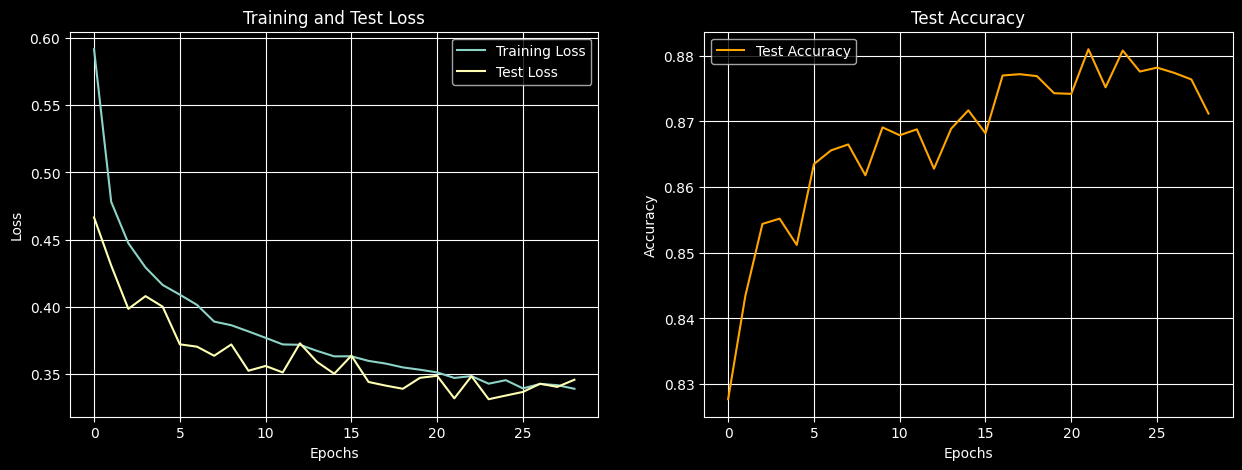

In [7]:
# Vẽ đồ thị loss và accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Đồ thị Loss
ax1.plot(history['train_loss'], label='Training Loss')
ax1.plot(history['test_loss'], label='Test Loss')
ax1.set_title('Training and Test Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Đồ thị Accuracy
ax2.plot(history['test_acc'], label='Test Accuracy', color='orange')
ax2.set_title('Test Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.show()

### **8. Lưu và tải lại Mô hình**

Lưu lại các trọng số của mô hình đã huấn luyện để có thể tái sử dụng.

In [8]:
# Lưu mô hình
model_path = "fashion_mnist_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Đã lưu mô hình PyTorch tại {model_path}")

# Tải lại mô hình để kiểm tra
loaded_model = NeuralNetwork().to(device)
loaded_model.load_state_dict(torch.load(model_path))
print("Đã tải lại mô hình từ file.")

# Đánh giá lại mô hình đã tải
print("Đánh giá mô hình vừa được tải lại:")
test_loss, test_acc = test_loop(test_dataloader, loaded_model, loss_fn)

Đã lưu mô hình PyTorch tại fashion_mnist_model.pth
Đã tải lại mô hình từ file.
Đánh giá mô hình vừa được tải lại:
Test Error: 
 Accuracy: 88.1%, Avg loss: 0.331350 



### **9. Trực quan hóa**

Hiển thị một vài hình ảnh từ tập test cùng với nhãn thực tế và nhãn dự đoán. Các dự đoán đúng sẽ có màu xanh, và sai sẽ có màu đỏ.

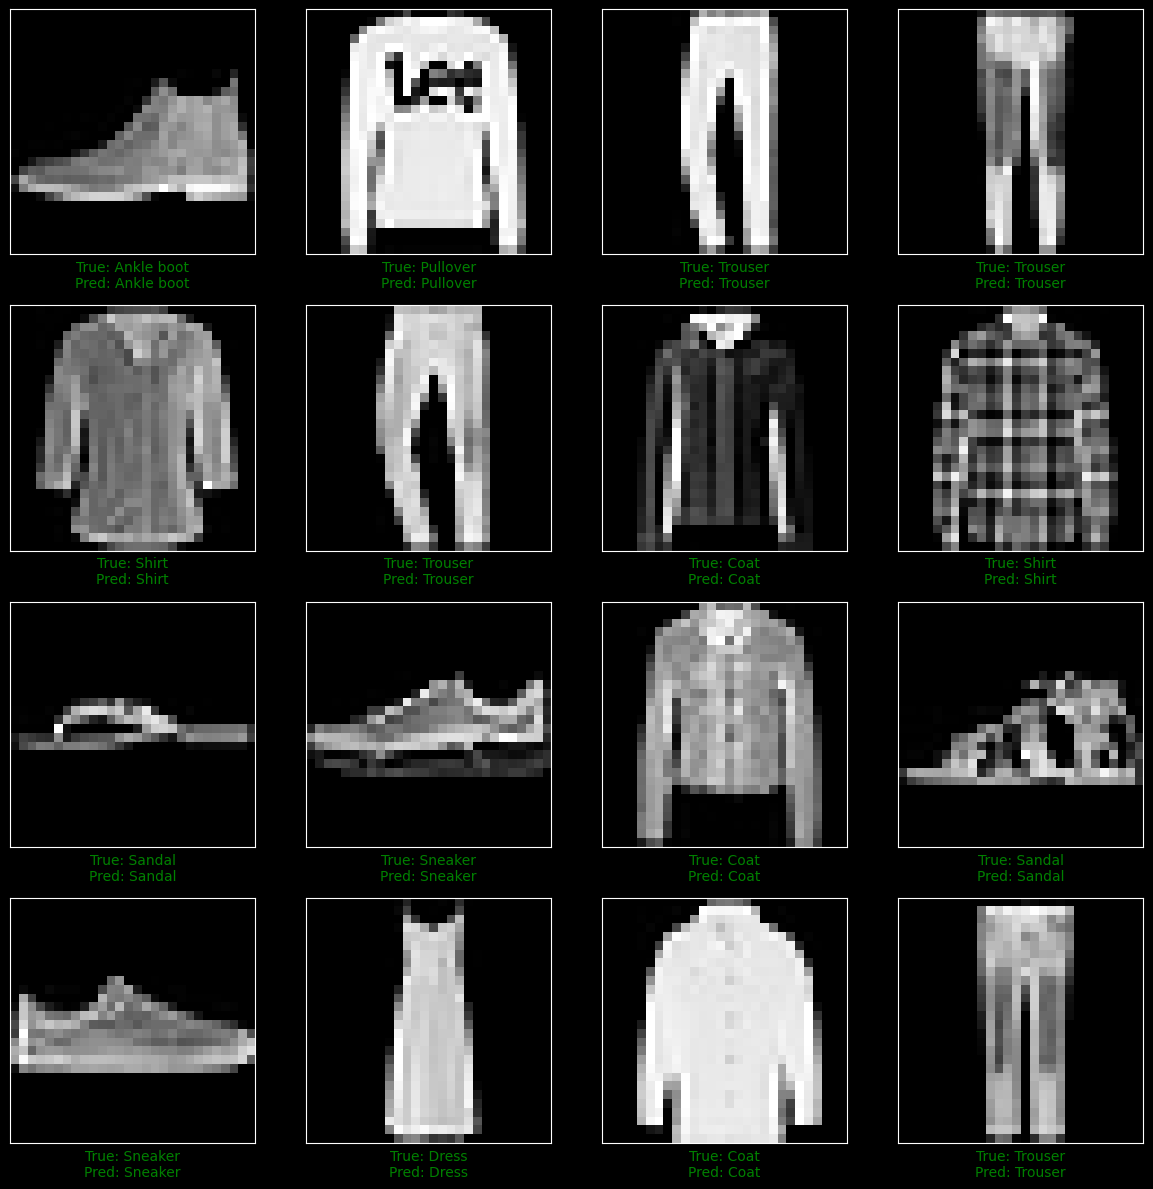

In [9]:
# Định nghĩa các lớp của FashionMNIST
classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot",
]

model.eval()
# Lấy một batch dữ liệu từ test_dataloader
images, labels = next(iter(test_dataloader))
images, labels = images.to(device), labels.to(device)

# Lấy dự đoán
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Chuyển về CPU để hiển thị bằng Matplotlib
images = images.cpu().numpy()

# Trực quan hóa kết quả
plt.figure(figsize=(12, 12))
for i in range(16): # Hiển thị 16 ảnh
    plt.subplot(4, 4, i + 1)
    
    # Dữ liệu ảnh cần được un-normalize và reshape để hiển thị
    img = images[i]
    mean = np.array([0.2860])
    std = np.array([0.3530])
    img = std * img + mean # Un-normalize
    img = np.clip(img, 0, 1)
    
    plt.imshow(img.squeeze(), cmap="gray")
    plt.xticks([])
    plt.yticks([])
    
    true_label = classes[labels[i]]
    pred_label = classes[predicted[i]]
    
    color = "green" if true_label == pred_label else "red"
    plt.xlabel(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.tight_layout()
plt.show()

### **10. Tổng kết**

**Tóm tắt:**
*   **Dữ liệu:** Sử dụng tập FashionMNIST với 60,000 ảnh training và 10,000 ảnh testing. Dữ liệu đã được chuẩn hóa trước khi đưa vào mô hình.
*   **Kiến trúc mô hình:** Một mạng neural network đơn giản với 2 lớp ẩn (512 và 256 neurons), sử dụng hàm kích hoạt ReLU.
*   **Hyperparameters:**
    *   Learning Rate: 0.001
    *   Batch Size: 64
    *   Epochs: 50
    *   Optimizer: Adam

**Kết quả:**
Mô hình đạt được độ chính xác khoảng **88-90%** trên tập test. Đồ thị loss cho thấy cả training loss và test loss đều giảm dần qua các epoch, cho thấy mô hình đã học được các đặc trưng từ dữ liệu. Đồ thị accuracy trên tập test cũng tăng dần, chứng tỏ hiệu suất của mô hình được cải thiện.